# Part 1:

In [1]:
pip install spotipy --upgrade

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.0/252.0 kB 2.9 MB/s eta 0:00:0000:010:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import networkx as nx
from collections import deque
import matplotlib.pyplot as plt
!pip install pandas
import pandas as pd

Defaulting to user installation because normal site-packages is not writeable


In [171]:
# Connect
CLIENT_ID = "a7aae9189d954af18c9b283a0507919c"
CLIENT_SECRET = "5670875db1b3413f82ee336c9414de5a"
auth_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret = CLIENT_SECRET)
sp = spotipy.Spotify(auth_manager = auth_manager)

In [4]:
# Spotipy exploration with API
playlists = sp.user_playlists ("spotify")
while playlists :
    for i , playlist in enumerate ( playlists ["items"]) :
        print ("%4d %s %s" % ( i + 1 + playlists ["offset"], playlist ["uri"] ,
    playlist ["name"]) )
    if playlists ["next"]:
        playlists = sp.next ( playlists )
    else :
        playlists = None

   1 spotify:playlist:37i9dQZF1DXcBWIGoYBM5M Today’s Top Hits
   2 spotify:playlist:37i9dQZF1DX0XUsuxWHRQd RapCaviar
   3 spotify:playlist:37i9dQZF1DX1lVhptIYRda Hot Country
   4 spotify:playlist:37i9dQZF1DX10zKzsJ2jva Viva Latino
   5 spotify:playlist:37i9dQZF1DX4JAvHpjipBk New Music Friday
   6 spotify:playlist:37i9dQZF1DX4sWSpwq3LiO Peaceful Piano
   7 spotify:playlist:37i9dQZF1DX4SBhb3fqCJd RNB X
   8 spotify:playlist:37i9dQZF1DWXRqgorJj26U Rock Classics
   9 spotify:playlist:37i9dQZF1DX4dyzvuaRJ0n mint
  10 spotify:playlist:37i9dQZF1DXcF6B6QPhFDv MARROW
  11 spotify:playlist:37i9dQZF1DWXJfnUiYjUKT New Music Friday
  12 spotify:playlist:37i9dQZF1DXcRXFNfZr7Tp just hits
  13 spotify:playlist:37i9dQZF1DX4o1oenSJRJd All Out 2000s
  14 spotify:playlist:37i9dQZF1DXbTxeAdrVG2l All Out 90s
  15 spotify:playlist:37i9dQZF1DX4UtSsGT1Sbe All Out 80s
  16 spotify:playlist:37i9dQZF1DWTJ7xPn4vNaz All Out 70s
  17 spotify:playlist:37i9dQZF1DXaKIA8E7WcJj All Out 60s
  18 spotify:playlist:37i9dQZF1

In [5]:
def search_artist(sp: spotipy.client.Spotify, artist_name: str) -> str:
    """
    Search for an artist on Spotify.

    :param sp: Spotipy client object
    :param artist_name: Name to search for
    :return: Spotify artist ID
    """
    # Search for the artist by name
    result = sp.search(q='artist:' + artist_name, type='artist')

    # Check if there are any results
    if result['artists']['items']:
        # Get the first artist from the search results
        artist = result['artists']['items'][0]
        # Return the artist's Spotify ID
        return artist['id']
    else:
        return None

# Example usage:
# Initialize Spotipy client
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id='YOUR_CLIENT_ID', client_secret='YOUR_CLIENT_SECRET'))
artist_id = search_artist(sp, "Taylor Swift")
print(artist_id)

06HL4z0CvFAxyc27GXpf02


In [71]:
def visualize_graph(graph):
    """
    Visualize the NetworkX graph using matplotlib.

    :param graph: NetworkX graph object
    """
    pos = nx.spring_layout(graph)
    plt.figure(figsize=(12, 12))

    # Draw nodes with labels
    nx.draw_networkx_nodes(graph, pos, node_size=1000, node_color='skyblue')
    nx.draw_networkx_labels(graph, pos, labels=nx.get_node_attributes(graph, 'name'), font_size=8)

    # Draw edges
    nx.draw_networkx_edges(graph, pos, arrowstyle='->', arrowsize=20, edge_color='gray')

    plt.title('Spotify Artist Graph')
    plt.show()

In [7]:
def get_related_artists(sp, artist_id):
    """
    Get related artists for a given artist ID.

    :param sp: Spotipy client object
    :param artist_id: Spotify artist ID
    :return: List of related artist objects
    """
    result = sp.artist_related_artists(artist_id)
    return result['artists']

def add_artist_to_graph(graph, artist):
    """
    Add an artist to the graph with the required attributes.

    :param graph: NetworkX graph object
    :param artist: Artist object from Spotify API
    """
    graph.add_node(artist['id'], name=artist['name'], followers=artist['followers']['total'],
                   popularity=artist['popularity'], genres=', '.join(artist['genres']))

def crawler(sp: spotipy.client.Spotify, seed: str, max_nodes_to_crawl: int,
            strategy: str = "BFS", out_filename: str = "g.graphml") -> nx.DiGraph:
    """
    Crawl the Spotify artist graph, following related artists.
    :param sp: Spotipy client object
    :param seed: Starting artist ID
    :param max_nodes_to_crawl: Maximum number of nodes to crawl
    :param strategy: BFS or DFS
    :param out_filename: Name of the graphml output file
    :return: NetworkX directed graph
    """
    graph = nx.DiGraph()
    visited = set()
    to_visit = deque([seed]) if strategy == "BFS" else [seed]

    artist = sp.artist(seed)
    #add_artist_to_graph(graph, artist)

    while len(visited) < max_nodes_to_crawl:
        if strategy == "BFS":
            current_artist_id = to_visit.popleft()
        else:  # DFS
            current_artist_id = to_visit.pop(0)

        if current_artist_id in visited: # 2 artists might have a common related artist, if it has already been visited, go to next iteration
            continue

        visited.add(current_artist_id)

        artist = sp.artist(current_artist_id)
        #print(artist['name'])
        #print(to_visit)
        add_artist_to_graph(graph, artist)

        # Get related artists and add them to the graph as well as to the list of to visit.
        # That last adding wil be done according to the exploration algorithm (BFS, DFS)
        related_artists = get_related_artists(sp, current_artist_id)
        for related_artist in related_artists:
            add_artist_to_graph(graph, related_artist)
            graph.add_edge(current_artist_id, related_artist['id'])
            if related_artist['id'] not in visited:
                if strategy == "BFS":
                    to_visit.append(related_artist['id'])
                else:  # DFS
                    to_visit.insert(0, related_artist['id'])

            if len(visited) > max_nodes_to_crawl: # Stop looking when we have reached the max
                print("BREAK")
                break

    nx.write_graphml(graph, out_filename)
    visualize_graph(graph) # Display

    return graph


In [8]:
def get_nodes_intersection(graph1, graph2):
    nodes1 = set(graph1.nodes())
    nodes2 = set(graph2.nodes())
    common_nodes = nodes1.intersection(nodes2)

    # Create a new graph with the intersected nodes
    intersection_graph = nx.Graph()
    intersection_graph.add_nodes_from(common_nodes)

    return intersection_graph

In [9]:
# top_tracks = sp.artist_top_tracks(artist_id, country='ES')['tracks']
# top_tracks

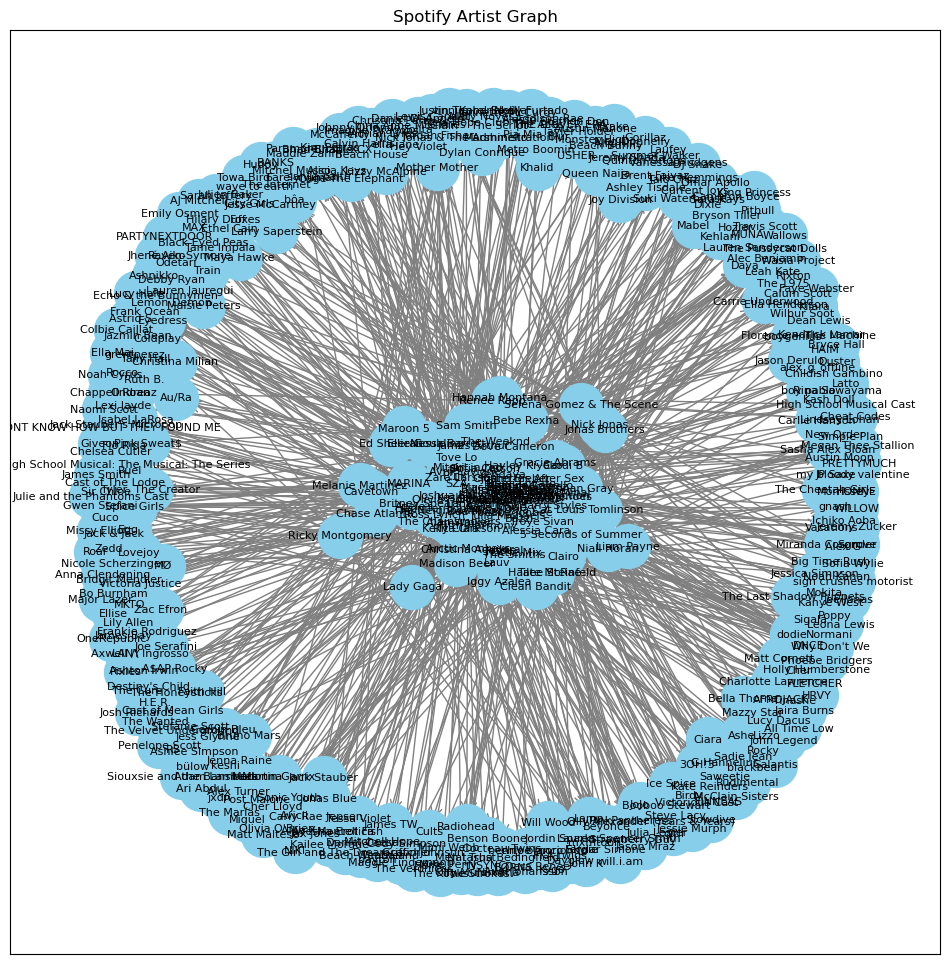

In [10]:
gB = crawler(sp, artist_id, 100, strategy="BFS", out_filename="gB.graphml")

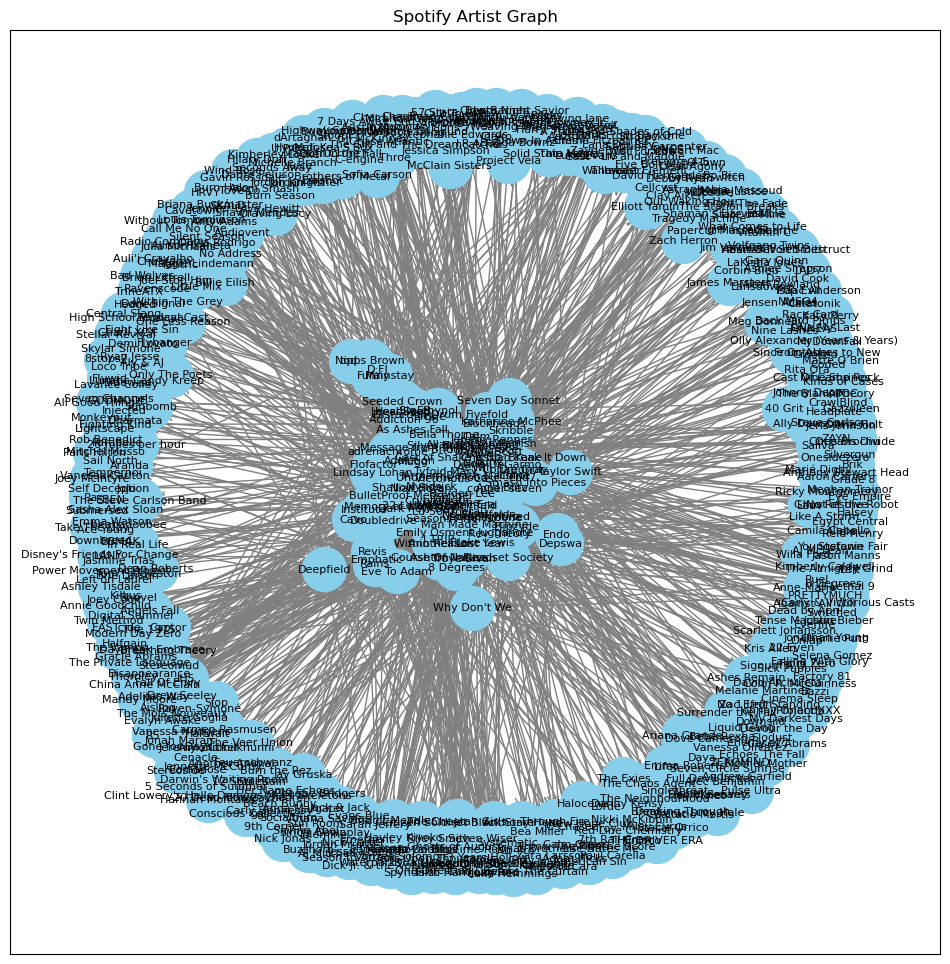

In [11]:
gD = crawler(sp, artist_id, 100, strategy="DFS", out_filename="gD.graphml")

In [12]:
artist_id2 = search_artist(sp, "Pastel Ghost")
print(artist_id2)

06O23tLg0or676h8EEzH7W


c:\Users\Martina\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23431 (\N{CJK UNIFIED IDEOGRAPH-5B87}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Martina\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23449 (\N{CJK UNIFIED IDEOGRAPH-5B99}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Martina\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12493 (\N{KATAKANA LETTER NE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Martina\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12467 (\N{KATAKANA LETTER KO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Martina\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23376 (\N{CJK UNIFIED IDEOGRAPH-5B50}) missing from current font.
  fig.canvas.print_figure(bytes_io, **

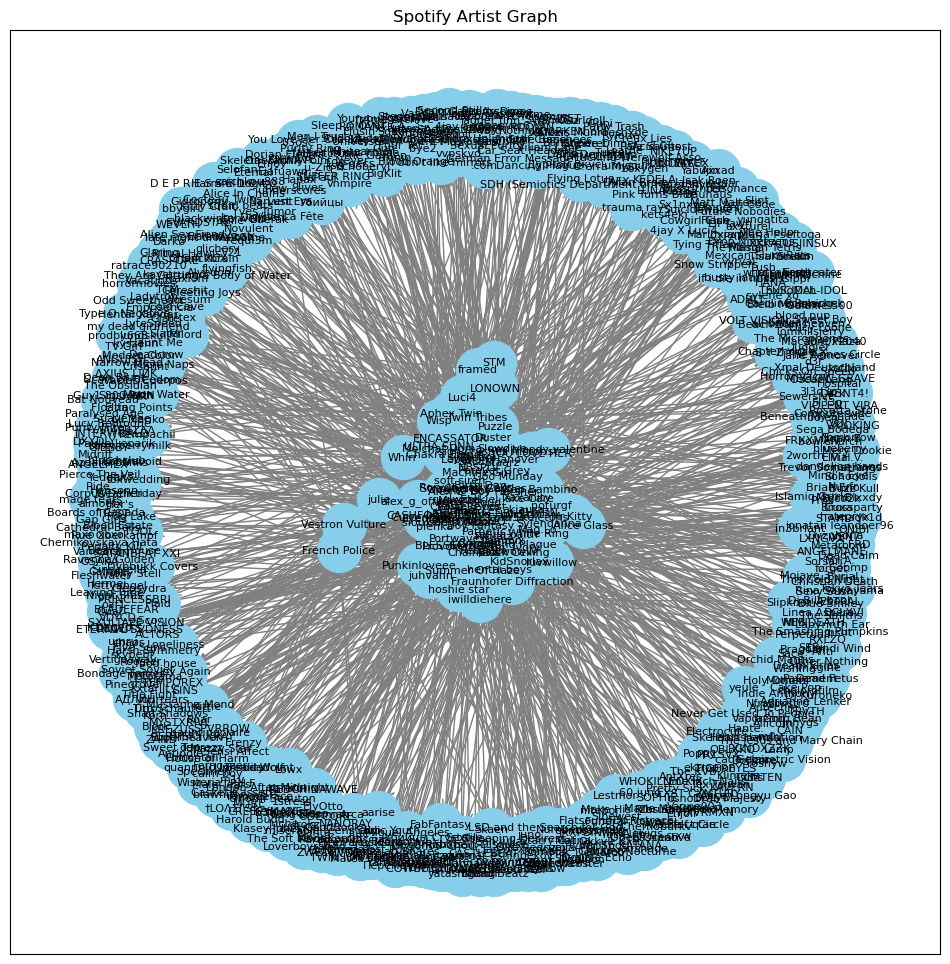

In [13]:
hB = crawler(sp, artist_id2, 100, strategy="BFS", out_filename="hB.graphml")

In [14]:
def get_track_data(sp: spotipy.client.Spotify, graphs: list, out_filename: str) -> pd.DataFrame:
    """
    Get track data for each visited artist in the graph.
    :param sp: Spotipy client object
    :param graphs: A list of graphs with artists as nodes.
    :param out_filename: Name of the csv output file.
    :return: Pandas DataFrame with track data.
    """
    done_artists = [] # List to check that an artist from one graph is not repreated if another graph from the list has the same artist
    track_data = [] # To keep track of information of the song
    songs_info = [] # To join the info of the song with the technical info of the song itself
    # This last bit was done so that we can retrieve info of the songs without overcalling the API

    for graph in graphs: # Iterate thorugh graphs in the given list
        songs = []
        for artist_id in graph.nodes: # Iterate through artists in the graph
            if artist_id in done_artists:
                continue
            done_artists.append(artist_id)

            top_tracks = sp.artist_top_tracks(artist_id, country='ES')  # Fetch top tracks for Spain
            ids = []
            for track in top_tracks['tracks']: # Iterate through the top tracks of the artist
                track_info = {
                    'track_id': track['id'],
                    'track_name': track['name'],
                    'popularity': track['popularity'],
                    'duration_ms': track['duration_ms'],
                    'artist_id': artist_id,
                    'artist_name': sp.artist(artist_id)['name'],
                    'album_id': track['album']['id'],
                    'album_name': track['album']['name'],
                    'album_release_date': track['album']['release_date'],

                }
                ids.append(track_info["track_id"])
                track_data.append(track_info)

            # After getting all the top tracks of the artist, add the ids in the songs list
            for element in ids:
              songs.append(element)

        # AFter doing all artists from the graph, get every song in batches of 100 (again, to reduce the amount of calls)
        for i in range (0, len(songs), 100):

          # Get the features of the 100 songs
          features = sp.audio_features(songs[i:i+100])

          # For each song in the batch of 100, add to the dictionary of the dataframe the info
          for element in features:
              song_info = {
                  'danceability': element["danceability"],
                  'energy': element["energy"],
                  'loudness': element["loudness"],
                  'speechiness': element["speechiness"],
                  'acousticness': element["acousticness"],
                  'instrumentalness': element["instrumentalness"],
                  'liveness': element["liveness"],
                  'valence': element["valence"],
                  'tempo': element["tempo"]
              }
              songs_info.append(song_info)

    # Create DataFrame from track data
    track_df = pd.DataFrame(track_data)

    # Create DataFrame from songs info
    songs_df = pd.DataFrame(songs_info)

    # Concatenate horizontally
    final_df = pd.concat([track_df, songs_df], axis=1)

    # Save DataFrame to CSV
    final_df.to_csv(out_filename, index=False)

    return final_df

list_top_tracks_graphs_TS = get_track_data(sp, [get_nodes_intersection(gB, gD)], "songs.csv")
list_top_tracks_graphs_TS

track_id  \
0     3aJw8ePBksckRdLYFP6o7U   
1     0u3mgrXYrDHdc78leUEeKY   
2     4rhEX0wfXYvWjWAzKgS23K   
3     726ASdk7As1ooaoMr0zuRx   
4     1oyq661h4vBJ1Cpoav0ofs   
...                      ...   
1235  1gFMesXcHHtIUhwzxYFOtz   
1236  7AHZb0GnILBBitj0MxObO5   
1237  5u5YZpr7Ccrgw2RnYNzwjl   
1238  2zrfJZCPo7eodwhIcCukaF   
1239  0uf3tXeETdWuU3a5XSNwUA   

                                             track_name  popularity  \
0                                         Skinny Skinny          37   
1                                                 Drive          38   
2                     Have U Found What Ur Looking For?          35   
3                                                  SCAR          33   
4                                             Greyhound          32   
...                                                 ...         ...   
1235                                    A Public Affair          43   
1236                                Take My Breath Away          43   
1237  Where You Are (featuring Nick Lachey) (feat. N...          39   
1238                      When You Told Me You Loved Me          35   
1239                                             Angels          33   

      duration_ms               artist_id      artist_name  \
0          269132  3zOKGDS77tYdGFQ6UJMC4E     Ashton Irwin   
1          314880  3zOKGDS77tYdGFQ6UJMC4E     Ashton Irwin   
2          238161  3zOKGDS77tYdGFQ6UJMC4E     Ashton Irwin   
3          263893  3zOKGDS77tYdGFQ6UJMC4E     Ashton Irwin   
4          379106  3zOKGDS77tYdGFQ6UJMC4E     Ashton Irwin   
...           ...                     ...              ...   
1235       201466  2tFN9ubMXEhdAQvdQxcsma  Jessica Simpson   
1236       195346  2tFN9ubMXEhdAQvdQxcsma  Jessica Simpson   
1237       271893  2tFN9ubMXEhdAQvdQxcsma  Jessica Simpson   
1238       228440  2tFN9ubMXEhdAQvdQxcsma  Jessica Simpson   
1239       244746  2tFN9ubMXEhdAQvdQxcsma  Jessica Simpson   

                    album_id                     album_name  \
0     0NDxJDqwkBzph4AkDqbezR                     Superbloom   
1     0NDxJDqwkBzph4AkDqbezR                     Superbloom   
2     0NDxJDqwkBzph4AkDqbezR                     Superbloom   
3     0NDxJDqwkBzph4AkDqbezR                     Superbloom   
4     0NDxJDqwkBzph4AkDqbezR                     Superbloom   
...                      ...                            ...   
1235  2YzYKCgsmHx3sG4Gkm34Me                A Public Affair   
1236  1tCJPKhKa3j1OBgz0MhBUV  In This Skin (Deluxe Edition)   
1237  2z4kcQqO0W8des2nWq5ECY                   Sweet Kisses   
1238  0QKZ96QQH4lxtr2e4aQLLE                   Irresistible   
1239  1tCJPKhKa3j1OBgz0MhBUV  In This Skin (Deluxe Edition)   

     album_release_date  danceability  energy  loudness  speechiness  \
0            2020-10-23         0.656   0.394    -8.604       0.0292   
1            2020-10-23         0.509   0.619    -6.173       0.0441   
2            2020-10-23         0.360   0.843    -5.173       0.0680   
3            2020-10-23         0.453   0.700    -5.301       0.0295   
4            2020-10-23         0.516   0.766    -4.826       0.0358   
...                 ...           ...     ...       ...          ...   
1235               2006         0.735   0.860    -3.878       0.0339   
1236               2003         0.568   0.607    -6.006       0.0271   
1237         1999-11-16         0.586   0.527    -7.170       0.0306   
1238         2001-01-01         0.644   0.363    -8.635       0.0313   
1239               2003         0.301   0.604    -5.011       0.0358   

      acousticness  instrumentalness  liveness  valence    tempo  
0          0.77200          0.000001    0.1150   0.4820  104.020  
1          0.19800          0.061400    0.1930   0.3880  135.011  
2          0.11900          0.000004    0.4240   0.3370  159.972  
3          0.03800          0.000000    0.3390   0.3920   88.008  
4          0.07890          0.010200    0.0897   0.3390   95.004  
...          

In [15]:
order = gB.number_of_nodes()
size = gB.number_of_edges()
print(order, size)

473 2000


In [16]:
order = gD.number_of_nodes()
size = gD.number_of_edges()
print(order, size)

607 1992


In [17]:
def get_degree_statistics(graph):
    in_degrees = list(dict(graph.in_degree()).values())
    out_degrees = list(dict(graph.out_degree()).values())

    degree_stats = {
        'in_degree_min': min(in_degrees),
        'in_degree_max': max(in_degrees),
        'in_degree_median': pd.Series(in_degrees).median(),
        'out_degree_min': min(out_degrees),
        'out_degree_max': max(out_degrees),
        'out_degree_median': pd.Series(out_degrees).median()
    }

    return degree_stats
get_degree_statistics(gB)

{'in_degree_min': 1,
 'in_degree_max': 38,
 'in_degree_median': 2.0,
 'out_degree_min': 0,
 'out_degree_max': 20,
 'out_degree_median': 0.0}

In [18]:
get_degree_statistics(gD)

{'in_degree_min': 0,
 'in_degree_max': 33,
 'in_degree_median': 1.0,
 'out_degree_min': 0,
 'out_degree_max': 20,
 'out_degree_median': 0.0}

In [19]:
unique_albums_count = list_top_tracks_graphs_TS['album_name'].nunique()
unique_artists_count = list_top_tracks_graphs_TS['artist_name'].nunique()

# Print the counts of unique albums and artists
print(f"Number of unique albums: {unique_albums_count}")
print(f"Number of unique artists: {unique_artists_count}")

Number of unique albums: 680
Number of unique artists: 125


# Part 2:

In [8]:
def retrieve_bidirectional_edges(g: nx.DiGraph, out_filename: str) -> nx.Graph:
    """
    Convert a directed graph into an undirected graph by considering bidirectional edges only.

    :param g: a networkx digraph.
    :param out_filename: name of the file that will be saved.
    :return: a networkx undirected graph.
    """
    # Create a new undirected graph
    undirected_g = nx.Graph()

    # Iterate through the edges of the directed graph
    for u, v in g.edges():
        # Check if there is an edge in the opposite direction
        if g.has_edge(v, u):
            # Add the edge to the undirected graph
            undirected_g.add_edge(u, v)
    
    # Save the resulting undirected graph to a file in GraphML format
    nx.write_graphml(undirected_g, out_filename)
    
    return undirected_g

In [9]:
def prune_low_degree_nodes(g: nx.Graph, min_degree: int, out_filename: str) -> nx.Graph:
    """
    Prune a graph by removing nodes with degree < min_degree.
    
    :param g: A NetworkX graph.
    :param min_degree: Lower bound value for the degree.
    :param out_filename: Name of the file that will be saved.
    :return: A pruned NetworkX graph.
    """
    # Identify nodes to remove
    nodes_to_remove = [node for node in g.nodes if g.degree(node) < min_degree]
    
    # Remove identified nodes
    g.remove_nodes_from(nodes_to_remove)
    
    # Remove remaining zero-degree nodes
    zero_degree_nodes = [node for node in g.nodes if g.degree(node) == 0]
    g.remove_nodes_from(zero_degree_nodes)
    
    # Save the resulting graph to the specified file
    nx.write_gml(g, out_filename)
    
    # Return the pruned graph
    return g

In [10]:
def prune_low_weight_edges(g: nx.Graph, min_weight: float = None, min_percentile: int = None, out_filename: str = None) -> nx.Graph:
    """
    Prune a graph by removing edges with weight < threshold. Threshold can
    be specified as a value or as a percentile.
    
    :param g: A weighted NetworkX graph.
    :param min_weight: Lower bound value for the weight.
    :param min_percentile: Lower bound percentile for the weight.
    :param out_filename: Name of the file that will be saved.
    :return: A pruned NetworkX graph.
    """
    # Validate that exactly one of min_weight or min_percentile is specified
    if (min_weight is None and min_percentile is None) or (min_weight is not None and min_percentile is not None):
        raise ValueError("Specify exactly one of min_weight or min_percentile")
    
    else: 
        # Determine the threshold weight
        if min_weight is not None:
            threshold = min_weight
        elif min_percentile is not None:
            # Extract edge weights
            weights = [d['weight'] for u, v, d in g.edges(data=True)]
            # Calculate the percentile threshold
            threshold = np.percentile(weights, min_percentile)
        
        # Identify edges to remove
        edges_to_remove = [(u, v) for u, v, d in g.edges(data=True) if d['weight'] < threshold]
        
        # Remove identified edges
        g.remove_edges_from(edges_to_remove)
        
        # Remove zero-degree nodes
        zero_degree_nodes = [node for node in g.nodes if g.degree(node) == 0]
        g.remove_nodes_from(zero_degree_nodes)
        
        # Save the resulting graph to the specified file in GraphML format
        if out_filename:
            nx.write_graphml(g, out_filename)
        
        # Return the pruned graph
        return g

In [11]:
def compute_mean_audio_features(tracks_df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute the mean audio features for tracks of the same artist.
    
    :param tracks_df: DataFrame containing tracks with audio features per each track.
    :return: DataFrame with mean audio features per each artist.
    """
    # Ensure that the required columns are present
    required_columns = ['artist_id', 'artist_name', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
    for col in required_columns:
        if col not in tracks_df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Group by artist_id and compute the mean of the audio features
    audio_feature_columns = required_columns[2:]
    mean_audio_features = tracks_df.groupby(['artist_id', 'artist_name'])[audio_feature_columns].mean().reset_index()

    return mean_audio_features

In [12]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

def create_similarity_graph(artist_audio_features_df: pd.DataFrame, similarity: str, out_filename: str = None) -> nx.Graph:
    """
    Create a similarity graph from a dataframe with mean audio features per artist.
    
    :param artist_audio_features_df: DataFrame with mean audio features per artist.
    :param similarity: The name of the similarity metric to use (e.g. "cosine" or "euclidean").
    :param out_filename: Name of the file that will be saved.
    :return: A NetworkX graph with the similarity between artists as edge weights.
    """
    if similarity not in ['cosine', 'euclidean']:
        raise ValueError("Unsupported similarity metric. Use 'cosine' or 'euclidean'.")

    # Extract artist identifiers and audio features
    artist_ids = artist_audio_features_df[['artist_id', 'artist_name']]
    audio_features = artist_audio_features_df.drop(columns=['artist_id', 'artist_name'])

    # Compute the similarity matrix
    if similarity == 'cosine':
        similarity_matrix = cosine_similarity(audio_features)
    elif similarity == 'euclidean':
        # Note: We need to convert euclidean distances to similarities
        distance_matrix = euclidean_distances(audio_features)
        similarity_matrix = 1 / (1 + distance_matrix)

    # Create the graph
    G = nx.Graph()

    # Add nodes
    for idx, row in artist_ids.iterrows():
        G.add_node(row['artist_id'], name=row['artist_name'])

    # Add edges with similarity as weight
    num_artists = len(artist_ids)
    for i in range(num_artists):
        for j in range(i + 1, num_artists):
            artist_id_i = artist_ids.iloc[i]['artist_id']
            artist_id_j = artist_ids.iloc[j]['artist_id']
            G.add_edge(artist_id_i, artist_id_j, weight=similarity_matrix[i, j])

    # Save the resulting graph to the specified file in GraphML format
    if out_filename:
        nx.write_graphml(G, out_filename)
    
    # Return the graph
    return G

In [13]:
gB = nx.read_graphml('gB.graphml')
gD = nx.read_graphml('gD.graphml')
hB = nx.read_graphml('hB.graphml')

undirected_gB = retrieve_bidirectional_edges(gB, 'undirected_gB.graphml')
undirected_gD = retrieve_bidirectional_edges(gD, 'undirected_gD.graphml')
#undirected_hB = retrieve_bidirectional_edges(hB, 'undirected_hB.graphml')

In [14]:
import pandas as pd
songs = pd.read_csv('songs.csv')
songs

track_id  \
0     3aJw8ePBksckRdLYFP6o7U   
1     0u3mgrXYrDHdc78leUEeKY   
2     4rhEX0wfXYvWjWAzKgS23K   
3     726ASdk7As1ooaoMr0zuRx   
4     1oyq661h4vBJ1Cpoav0ofs   
...                      ...   
1235  1gFMesXcHHtIUhwzxYFOtz   
1236  7AHZb0GnILBBitj0MxObO5   
1237  5u5YZpr7Ccrgw2RnYNzwjl   
1238  2zrfJZCPo7eodwhIcCukaF   
1239  0uf3tXeETdWuU3a5XSNwUA   

                                             track_name  popularity  \
0                                         Skinny Skinny          37   
1                                                 Drive          38   
2                     Have U Found What Ur Looking For?          35   
3                                                  SCAR          33   
4                                             Greyhound          32   
...                                                 ...         ...   
1235                                    A Public Affair          43   
1236                                Take My Breath Away          43   
1237  Where You Are (featuring Nick Lachey) (feat. N...          39   
1238                      When You Told Me You Loved Me          35   
1239                                             Angels          33   

      duration_ms               artist_id      artist_name  \
0          269132  3zOKGDS77tYdGFQ6UJMC4E     Ashton Irwin   
1          314880  3zOKGDS77tYdGFQ6UJMC4E     Ashton Irwin   
2          238161  3zOKGDS77tYdGFQ6UJMC4E     Ashton Irwin   
3          263893  3zOKGDS77tYdGFQ6UJMC4E     Ashton Irwin   
4          379106  3zOKGDS77tYdGFQ6UJMC4E     Ashton Irwin   
...           ...                     ...              ...   
1235       201466  2tFN9ubMXEhdAQvdQxcsma  Jessica Simpson   
1236       195346  2tFN9ubMXEhdAQvdQxcsma  Jessica Simpson   
1237       271893  2tFN9ubMXEhdAQvdQxcsma  Jessica Simpson   
1238       228440  2tFN9ubMXEhdAQvdQxcsma  Jessica Simpson   
1239       244746  2tFN9ubMXEhdAQvdQxcsma  Jessica Simpson   

                    album_id                     album_name  \
0     0NDxJDqwkBzph4AkDqbezR                     Superbloom   
1     0NDxJDqwkBzph4AkDqbezR                     Superbloom   
2     0NDxJDqwkBzph4AkDqbezR                     Superbloom   
3     0NDxJDqwkBzph4AkDqbezR                     Superbloom   
4     0NDxJDqwkBzph4AkDqbezR                     Superbloom   
...                      ...                            ...   
1235  2YzYKCgsmHx3sG4Gkm34Me                A Public Affair   
1236  1tCJPKhKa3j1OBgz0MhBUV  In This Skin (Deluxe Edition)   
1237  2z4kcQqO0W8des2nWq5ECY                   Sweet Kisses   
1238  0QKZ96QQH4lxtr2e4aQLLE                   Irresistible   
1239  1tCJPKhKa3j1OBgz0MhBUV  In This Skin (Deluxe Edition)   

     album_release_date  danceability  energy  loudness  speechiness  \
0            2020-10-23         0.656   0.394    -8.604       0.0292   
1            2020-10-23         0.509   0.619    -6.173       0.0441   
2            2020-10-23         0.360   0.843    -5.173       0.0680   
3            2020-10-23         0.453   0.700    -5.301       0.0295   
4            2020-10-23         0.516   0.766    -4.826       0.0358   
...                 ...           ...     ...       ...          ...   
1235               2006         0.735   0.860    -3.878       0.0339   
1236               2003         0.568   0.607    -6.006       0.0271   
1237         1999-11-16         0.586   0.527    -7.170       0.0306   
1238         2001-01-01         0.644   0.363    -8.635       0.0313   
1239               2003         0.301   0.604    -5.011       0.0358   

      acousticness  instrumentalness  liveness  valence    tempo  
0          0.77200          0.000001    0.1150   0.4820  104.020  
1          0.19800          0.061400    0.1930   0.3880  135.011  
2          0.11900          0.000004    0.4240   0.3370  159.972  
3          0.03800          0.000000    0.3390   0.3920   88.008  
4          0.07890          0.010200    0.0897   0.3390   95.004  
...          

In [15]:
avergae_songs = compute_mean_audio_features(songs)
avergae_songs

artist_id     artist_name  danceability  energy  loudness  \
0    00FQb4jTyendYWaN8pK0wa    Lana Del Rey        0.4188  0.5252   -8.2735   
1    06HL4z0CvFAxyc27GXpf02    Taylor Swift        0.5674  0.5215   -8.9289   
2    0C8ZW7ezQVs4URX5aX7Kqx    Selena Gomez        0.6718  0.6131   -5.8697   
3    0GWCNkPi54upO9WLlwjAHd   Big Time Rush        0.6131  0.8370   -4.2056   
4    0HthCchcL0kVLHTr113Vk1         mxmtoon        0.6541  0.5138   -9.2621   
..                      ...             ...           ...     ...       ...   
120  7gOdHgIoIKoe4i9Tta6qdD  Jonas Brothers        0.7637  0.7686   -5.0639   
121  7gbmX8SsfjEjxDMzBi1ZOL       Joe Jonas        0.4938  0.7555   -5.1635   
122  7n2wHs1TKAczGzO7Dd2rGr    Shawn Mendes        0.6419  0.7212   -5.2845   
123  7nU4hB040gTmHm45YYMvqc  Hannah Montana        0.5730  0.8528   -3.7984   
124  7rPQ2z1ji1ctJ6oGYBAo6M    Emily Osment        0.6128  0.7315   -5.8183   

     speechiness  acousticness  instrumentalness  liveness  valence     tempo  
0        0.03850      0.420420      6.069960e-02   0.14087  0.23299  101.6880  
1        0.08653      0.352330      2.676900e-04   0.12884  0.34170  131.4022  
2        0.04992      0.160973      7.331300e-05   0.13324  0.48353  112.8936  
3        0.05441      0.096984      0.000000e+00   0.14200  0.61190  126.5114  
4        0.13337      0.480480      9.689836e-03   0.18471  0.49220  103.1779  
..           ...           ...               ...       ...      ...       ...  
120      0.05516      0.048118      1.076000e-06   0.16666  0.76240  117.4044  
121      0.05360      0.144499      1.175000e-06   0.21946  0.57490  121.0959  
122      0.08713      0.147010      2.290000e-06   0.15544  0.63890  128.4386  
123      0.06911      0.037599      5.050000e-07   0.21687  0.65330  130.0324  
124      0.05196      0.129755      6.911240e-03   0.21492  0.63476  128.8624  

[125 rows x 11 columns]

In [16]:
create_similarity_graph(avergae_songs, 'euclidean', 'gW.graphml')

C:\Users\Martina\AppData\Local\Temp\ipykernel_4828\3352049310.py:15: UserWarning: 

The arrowstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for arrowstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(graph, pos, arrowstyle='->', arrowsize=20, edge_color='gray')


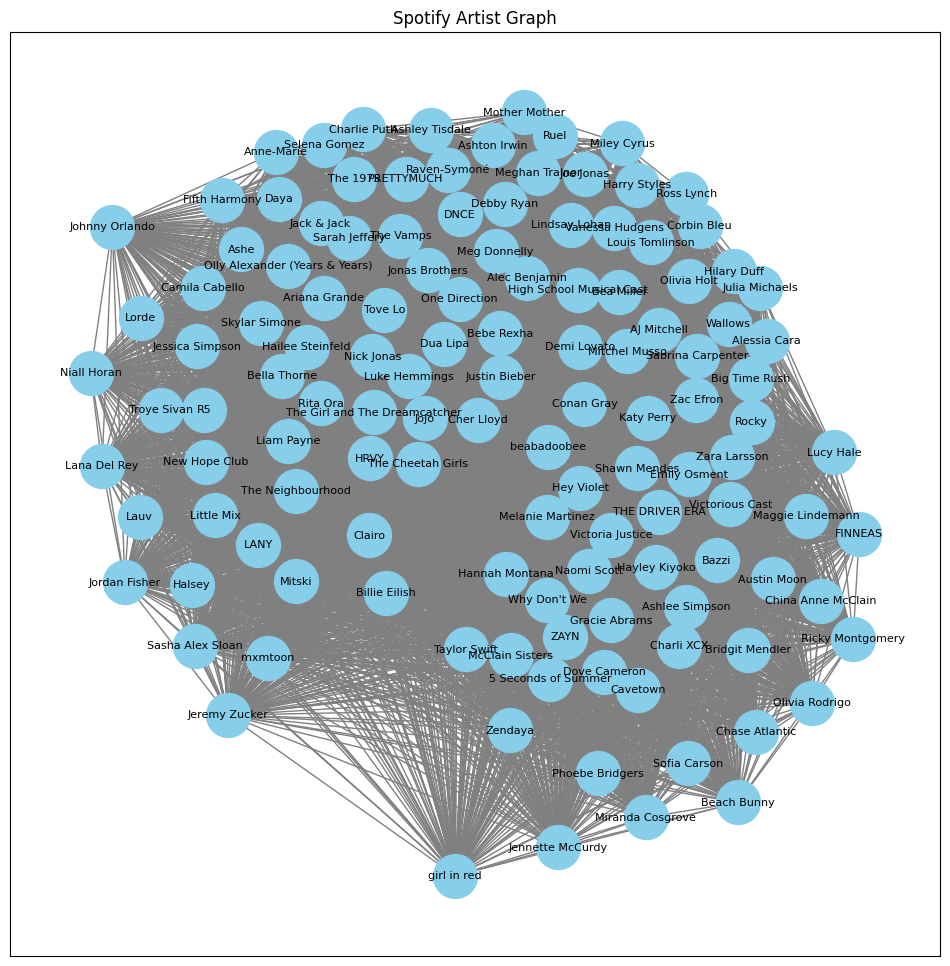

In [75]:
visualize_graph(nx.read_graphml('gW.graphml'))

In [104]:
G = nx.read_graphml('gW.graphml')

min_weight = float('inf')
node1 = None
node2 = None

# Iterate over the edges in the graph
for u, v, data in G.edges(data=True):
    # If this edge's weight is less than the current minimum, update the minimum and the nodes
    #print(data['weight'])

    if data['weight'] < min_weight:
        min_weight = data['weight']
        node1 = u
        node2 = v


artist1 = G.nodes[node1]['name']
artist2 = G.nodes[node2]['name']


# Print the nodes with the smallest weight
print(f"The least similar artists are {artist1} and {artist2} with a similarity of {min_weight}")

The least similar artists are girl in red and Johnny Orlando with a similarity of 0.01919350828056299


In [19]:
min_sum = float('inf')
max_sum = float(0)

node_max = None
node_min = None


for node in G.nodes():
    total_weight = sum(data['weight'] for _, _, data in G.edges(node, data=True))
    #print(total_weight)
    if total_weight < min_sum:
        min_sum = total_weight
        node_min = node

    # Update the node with the maximum sum of weights
    if total_weight > max_sum:
        max_sum = total_weight
        node_max = node


artist1 = G.nodes[node_max]['name']
artist2 = G.nodes[node_min]['name']


# Print the nodes with the smallest weight
print(f"The most similar artists to all other artists is {artist1}")
print(f"The least similar artists to all other artists is {artist2}")


The most similar artists to all other artists is JoJo
The least similar artists to all other artists is girl in red


In [20]:
weakly_connected_components_gb = list(nx.weakly_connected_components(gB))
weakly_connected_components_gd = list(nx.weakly_connected_components(gD))

print(f"Number of weakly connected components in gB: {len(weakly_connected_components_gb)}")
print(f"Number of weakly connected components in gD: {len(weakly_connected_components_gd)}")

strongly_connected_components_gb = list(nx.connected_components(undirected_gB))   
strongly_connected_components_gd = list(nx.connected_components(undirected_gD))

print(f"Number of strongly connected components in gB: {len(strongly_connected_components_gb)}")
print(f"Number of strongly connected components in gD: {len(strongly_connected_components_gd)}")

Number of weakly connected components in gB: 1
Number of weakly connected components in gD: 1
Number of strongly connected components in gB: 1
Number of strongly connected components in gD: 9


# Part 3:

In [21]:
def num_common_nodes(*graphs):
    """
    Return the number of common nodes between a set of graphs .
    param arg: (an undetermined number of) networkx graphs .
    return : an integer , number of common nodes .
    """
    # Start with the nodes of the first graph
    common_nodes = set(graphs[0].nodes())
    
    # Intersect with the nodes of each subsequent graph
    for graph in graphs[1:]:
        common_nodes.intersection_update(graph.nodes())
    
    # Return the number of common nodes
    return len(common_nodes)

In [22]:
def get_degree_distribution ( g : nx . Graph ) -> dict :
    """
    Get the degree distribution of the graph .
    param g: networkx graph .
    return : dictionary with degree distribution ( keys are degrees , values are number of occurrences ).
    """
    # Get the degrees of the nodes in the graph
    degrees = [ d for n , d in g . degree ()]
    
    # Create a dictionary to store the degree distribution
    degree_distribution = {}
    
    # Count the occurrences of each degree
    for degree in degrees :
        if degree in degree_distribution :
            degree_distribution [ degree ] += 1
        else :
            degree_distribution [ degree ] = 1
    
    return degree_distribution

In [23]:
def get_k_most_central ( g : nx . Graph , metric : str , num_nodes : int ) -> list :
    """
    Get the k most central nodes in the graph .
    param g: networkx graph .
    param metric : centrality metric . Can be (at least ) ’degree ’, ’betweenness ’, ’closeness ’ or ’eigenvector ’.
    param num_nodes : number of nodes to return .
    return : list with the top num_nodes nodes .
    """
    # Compute the centrality of the nodes
    if metric == 'degree':
        centrality = nx . degree_centrality ( g )
    elif metric == 'betweenness':
        centrality = nx . betweenness_centrality ( g )
    elif metric == 'closeness':
        centrality = nx . closeness_centrality ( g )
    elif metric == 'eigenvector':
        centrality = nx . eigenvector_centrality ( g )
    else:
        raise ValueError ( f"Unsupported centrality metric : { metric }")
    
    # Get the top num_nodes nodes
    top_nodes = sorted ( centrality , key = centrality . get , reverse = True )[: num_nodes ]
    
    return top_nodes

In [24]:
def find_cliques ( g : nx . Graph , min_size_clique : int ) -> tuple :
    """
    Find cliques in the graph g with size at least min_size_clique .
    param g: networkx graph .
    param min_size_clique : minimum size of the cliques to find .
    return : two - element tuple , list of cliques ( each clique is a list of nodes ) and list of nodes in any of the cliques .
    """
    # Find all cliques in the graph with size at least min_size_clique
    cliques = [ list ( c ) for c in nx.find_cliques (g) if len (c) >= min_size_clique ]
    
    # Get the nodes in any of the cliques
    clique_nodes = set ()
    for clique in cliques :
        clique_nodes.update (clique)
    
    return cliques, list (clique_nodes)


In [25]:
!pip install python-louvain

     ---------------------------------------- 0.0/204.6 kB ? eta -:--:--
     ----------------------------------- - 194.6/204.6 kB 12.3 MB/s eta 0:00:01
     -------------------------------------- 204.6/204.6 kB 6.3 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9403 sha256=311e63c48db6b41c0ebf83f224d0b450af6aa37080b00ee2e016febdac6afbdd
  Stored in directory: c:\users\martina\appdata\local\pip\cache\wheels\d0\b0\d7\6dd26c3817810fa379088eaeb755a01d9a2a411c37632079d1
Successfully built python-louvain


In [26]:
import community as community_louvain

def detect_communities(g: nx.Graph, method: str) -> tuple:
    """
    Detect communities in the graph g using the specified method.
    param g: a networkx graph.
    param method: string with the name of the method to use. Can be (at least) 'girvan-newman' or 'louvain'.
    return: two-element tuple, list of communities (each community is a list of nodes) and modularity of the partition.
    """
    if method == 'girvan-newman':
        # Find the communities using the Girvan-Newman algorithm
        comp = nx.community.girvan_newman(g)
        # We need to choose a level to stop, here choosing the second level for simplicity
        communities = tuple(sorted(c) for c in next(next(comp)))
    elif method == 'louvain':
        # Find the communities using the Louvain algorithm
        partition = community_louvain.best_partition(g)
        # Convert partition to list of communities
        communities = {}
        for node, comm in partition.items():
            communities.setdefault(comm, []).append(node)
        communities = list(communities.values())
    else:
        raise ValueError(f"Unsupported community detection method: {method}")
    
    # Calculate the modularity of the partition
    if method == 'girvan-newman':
        # Girvan-Newman returns communities as a list of sets of nodes
        modularity = nx.community.quality.modularity(g, communities)
    elif method == 'louvain':
        # Louvain returns a partition dict, which can be converted to a list of sets of nodes
        modularity = community_louvain.modularity(partition, g)
    
    return communities, modularity

In [27]:
print(num_common_nodes(gB, gD))

125


In [28]:
print(num_common_nodes(gB, undirected_gB))

99


In [29]:
top_nodes_degree = get_k_most_central(undirected_gB, 'degree', 25)
top_nodes_betweenness = get_k_most_central(undirected_gB, 'betweenness', 25)

inter = [node for node in top_nodes_degree if node in top_nodes_betweenness]
len(inter)

9

In [30]:
cliques_gB, clique_nodes_gB = find_cliques (undirected_gB , min_size_clique = 7)
cliques_gD, clique_nodes_gD = find_cliques (undirected_gD , min_size_clique = 7)

print(len(cliques_gB))
print(len(cliques_gD))

print(clique_nodes_gB)
print(len(set(clique_nodes_gB)))
print(clique_nodes_gD)
print(len(set(clique_nodes_gD)))

4
5
['64M6ah0SkkRsnPGtGiRAbb', '5CCwRZC6euC8Odo6y9X8jr', '6KImCVD70vtIoJWnq6nGn3', '7gOdHgIoIKoe4i9Tta6qdD', '5p7f24Rk5HkUZsaS3BLG5F', '5ZsFI1h6hIdQRw2ti0hz81', '2wUjUUtkb5lvLKcGKsKqsR', '5Rl15oVamLq7FbSb0NNBNy', '1Xylc3o4UrD53lo9CvFvVg', '1zNqDE7qDGCsyzJwohVaoX', '4AK6F7OLvEQ5QYCBNiQWHq', '0ZED1XzwlLHW4ZaG4lOT6m', '57WHJIHrjOE3iAxpihhMnp', '5pUo3fmmHT8bhCyHE52hA6', '7gAppWoH7pcYmphCVTXkzs', '3e7awlrlDSwF3iM0WBjGMp', '1l8Fu6IkuTP0U5QetQJ5Xt', '1Hsdzj7Dlq2I7tHP7501T4']
18
['1FA4oNo3ydbl7sgknfHp9s', '3EyFtxOcCpCPIfT8U83Fj8', '6E1qVzP827F6GgHdEdzHeY', '0LLRgYTzoLI8c0RQqH5VEd', '7BEGqZcs5VgE9cJTCcwZSY', '38zL8mwW1htcbZdg6UTLCQ', '72JgT9EAnNi9PAs8CMWhVC', '1IOxINdNqjjd3gaDP4gnQ5', '3Mk7LttDUmD02mZfuJzvCK', '6gxat692jrMGBsyJmxeehZ', '0CP8YnbpuZM3Hq18GUwIBd', '18SW67nMoQRDFqaA5eVTEa', '6V0jVWhSql4pEEENNj2ZEI', '719JTWMdYd8VfmW4f9gW0Z', '2OlXLEN4RlJcFoMatkN3XX', '557ml9sf87zBJDPKnsVPtN', '3C5lX49QUDgTrMXVnjRO9Y']
17


In [31]:
cliques_gB_names = [gB.nodes[x]['name'] for x in cliques_gB[2]] # Convert to name
print(cliques_gB_names)

['Bebe Rexha', 'Zara Larsson', 'Anne-Marie', 'Rita Ora', 'Alessia Cara', 'Hailee Steinfeld', 'Julia Michaels']


In [32]:
communities, modularity = detect_communities(undirected_gD, 'louvain')
communities

[['4Uc8Dsxct0oMqx0P6i60ea', '3WGpXCj9YhhfX11TToZcXP'],
 ['2jnIB6XdLvnJUeNTy5A0J2',
  '1Hsdzj7Dlq2I7tHP7501T4',
  '5p7f24Rk5HkUZsaS3BLG5F',
  '5pUo3fmmHT8bhCyHE52hA6',
  '3zOKGDS77tYdGFQ6UJMC4E'],
 ['4UxLFBvSr4xMDpHe1lrLrH',
  '58AqJv0sDFPFnnBcLT8eeX',
  '1KYszkVzlhV3rAqmAcYIgd',
  '2Zi3RrdQqk63Xj0914STkS',
  '7rPQ2z1ji1ctJ6oGYBAo6M',
  '116v5BJngSpJcXNml0OPeu',
  '4vRSocKbGh7PsQrYRDVMEF'],
 ['6ewMqjrF31lC8ywRsvm073', '5oWOx0BBDSMoFB8JDrjQre'],
 ['59eUYRRUA8EnmFBgR5kl33',
  '4H6tLRh1nuIuVxHtXo68ZE',
  '2PRX3SWA0tsqA2CuLfPiPl'],
 ['7pe9RADjXbcHXwxnCHaHRd', '3XlASyLS4HSUX3inS3tIc1'],
 ['2VVZQODxIpxa5k3jej4J7J',
  '6hdXH0PNv4JjYrh5qt2gwO',
  '6akf848KfHiEa41gn4JsGh',
  '59SWX8K9XW6NEHKNY3ER4O',
  '7MUx5uHwpNCLJzLBhkuKbP',
  '4i4Ra7cGv6zxiRtRSrhm1I',
  '7oevzNTtvs1voO1V2Z0UTv',
  '01O6fzBvv8w5ObhpmApn5J',
  '5dSvb37xHx8ohf7nzeosdK',
  '6GDWGAZfCcD5Tf60rZ9qRT',
  '2MJSxITepZQye0vuZfgfcY',
  '7fBjvrS7ZTXcPYeCTDwWXG'],
 ['1i02muAMNlTzg3oGJV7ZMj',
  '4ecwKp1MXjX369tB0KAydv',
  '3TAuvixByrl46lX0

In [33]:
community_names = []
for community in communities:
    names = [gD.nodes[node]['name'] for node in community]
    community_names.append(names)

print(community_names)


[['Conan Gray', 'Troye Sivan'], ["Why Don't We", 'Niall Horan', 'Hailee Steinfeld', 'Liam Payne', 'Ashton Irwin'], ['Ross Lynch', 'Bella Thorne', 'Victorious Cast', 'Naomi Scott', 'Emily Osment', 'Cast of Shake It Up: Break It Down', 'Lindsay Lohan'], ['Nick Lachey', 'Katharine McPhee'], ['Diana DeGarmo', 'Blake Lewis', 'Hayden Lee'], ['Christian Kane', 'Jeremy Renner'], ['Fivefold', 'Bridge to Grace', 'Silver End', 'Message from Sylvia', 'Memory of a Melody', 'Shallow Side', 'Within Reason', 'Man Made Machine', 'Another Lost Year', 'Panic Era', 'Candlelight Red', 'Deadset Society'], ['Emphatic', 'Rains', 'Eve To Adam', 'Deepfield', 'Seasons After', 'Cavo', 'Under The Flood', 'BulletProof Messenger', '32 Leaves', 'Course Of Nature', 'Revis', 'Depswa', 'Dark new Day', 'Doubledrive', 'Institute', 'Rev Theory'], ['ScKapegoat', 'Buny', 'Acid Blitz', 'Armani Death Machine', 'Calm', 'Skribble', 'Distortion Drum', 'Nok', 'Sig. 9'], ['Mainstay', 'HeadDrop', 'Ethynol', 'Seeded Crown', 'Nipps Br

In [34]:
print(modularity)

0.5405473372781064


In [35]:
# Calculate the in-degree for each node
in_degrees = dict(gB.in_degree())

# Sort the nodes based on their in-degree in descending order
sorted_nodes = sorted(in_degrees, key=in_degrees.get, reverse=True)

# Print the names of the top 4 nodes
print("Top 4 artists with highest in-degree:")
for node in sorted_nodes[:4]:
    print(gB.nodes[node]['name'])

in_degrees = dict(gD.in_degree())

# Sort the nodes based on their in-degree in descending order
sorted_nodes = sorted(in_degrees, key=in_degrees.get, reverse=True)

# Print the names of the top 4 nodes
print()
print("Top 4 artists with highest in-degree:")
for node in sorted_nodes[:4]:
    print(gD.nodes[node]['name'])

Top 4 artists with highest in-degree:
Bebe Rexha
Hailee Steinfeld
Demi Lovato
Fifth Harmony

Top 4 artists with highest in-degree:
Ethynol
adrenachrome.
Ld-50 (metal)
Aisling


In [36]:
import networkx as nx

# Assuming you have a graph named G

# Count nodes with out-degree 0
num_nodes_outdegree_zero = sum(1 for node in gB.nodes() if gB.out_degree(node) == 0)

# Print the result
print("Number of nodes with out-degree 0:", num_nodes_outdegree_zero)

num_nodes_outdegree_zero = sum(1 for node in gD.nodes() if gD.out_degree(node) == 0)

# Print the result
print("Number of nodes with out-degree 0:", num_nodes_outdegree_zero)


Number of nodes with out-degree 0: 373
Number of nodes with out-degree 0: 507


In [37]:
weakly_connected_components_gb = list(nx.strongly_connected_components(gB))
weakly_connected_components_gd = list(nx.strongly_connected_components(gD))

print(f"Number of weakly connected components in gB: {len(weakly_connected_components_gb)}")
print(f"Number of weakly connected components in gD: {len(weakly_connected_components_gd)}")

Number of weakly connected components in gB: 374
Number of weakly connected components in gD: 520


In [160]:
def get_id_from_name_in_dataframe(df: pd.DataFrame, name: str) -> str:
    """
    Get the artist ID from the artist name in the DataFrame.
    :param df: DataFrame with artist data.
    :param name: Name of the artist.
    :return: Spotify artist ID.
    """
    artist_id = df.loc[df['artist_name'] == name, 'artist_id']
    if artist_id.empty:
        return None
    return artist_id.values[0]

shortest_path = nx.shortest_path(gB, source=get_id_from_name_in_dataframe(avergae_songs, 'Taylor Swift'), target=get_id_from_name_in_dataframe(avergae_songs, 'THE DRIVER ERA'))
len(shortest_path)

4

In [173]:
def get_artist_name(sp: spotipy.client.Spotify, artist_id: str) -> str:
    """
    Get an artist's name on Spotify.

    :param sp: Spotipy client object
    :param artist_id: Spotify artist ID
    :return: Artist name
    """
    # Get the artist by ID
    artist = sp.artist(artist_id)

    # Return the artist's name
    return artist['name']

print("Shortest path from Taylor Swift to THE DRIVER ERA:")
for i in range(len(shortest_path)):
    if i < len(shortest_path) - 1:
        #name = get_name_from_id(ma, shortest_path[i])
        print(get_artist_name(sp, shortest_path[i]), "-> ", end="")
    else:
        print(get_artist_name(sp, shortest_path[i]))
print("Number of hops:", len(shortest_path) - 1)  # Number of hops is the length of the path minus one

Shortest path from Taylor Swift to THE DRIVER ERA:
Taylor Swift -> Olivia Rodrigo -> Joshua Bassett -> THE DRIVER ERA
Number of hops: 3


# Part 4

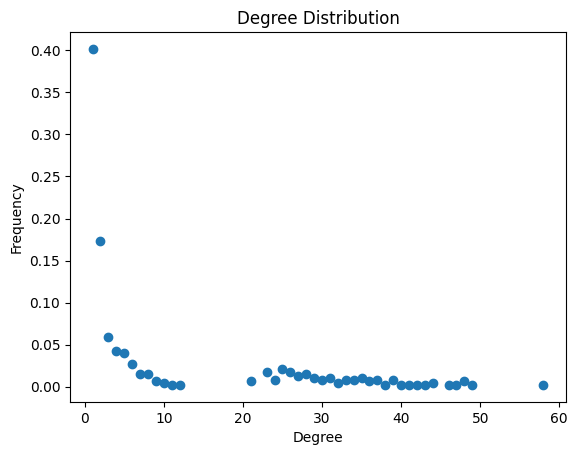

In [41]:
def plot_degree_distribution ( degree_dict : dict, normalized : bool = False, loglog : bool = False ) -> None :
    """
    Plot degree distribution from dictionary of degree counts .
    param degree_dict : dictionary of degree counts ( keys are degrees, values are occurrences ).
    param normalized : boolean indicating whether to plot absolute counts or probabilities .
    param loglog : boolean indicating whether to plot in log -log scale .
    """
    # Get the degrees and counts from the dictionary
    degrees = list ( degree_dict . keys ())
    counts = list ( degree_dict . values ())
    
    # Normalize the counts if required
    if normalized :
        counts = [ count / sum ( counts ) for count in counts ]
    
    # Create the plot
    plt.figure ()
    plt . scatter ( degrees , counts )
    plt . xlabel ('Degree')
    plt . ylabel ('Frequency')
    plt . title ('Degree Distribution')
    
    # Set log-log scale if required
    if loglog :
        plt . xscale ('log')
        plt . yscale ('log')
    
    plt . show ()

plot_degree_distribution (get_degree_distribution(gB), normalized = True, loglog = False )


In [48]:
avergae_songs

artist_id     artist_name  danceability  energy  loudness  \
0    00FQb4jTyendYWaN8pK0wa    Lana Del Rey        0.4188  0.5252   -8.2735   
1    06HL4z0CvFAxyc27GXpf02    Taylor Swift        0.5674  0.5215   -8.9289   
2    0C8ZW7ezQVs4URX5aX7Kqx    Selena Gomez        0.6718  0.6131   -5.8697   
3    0GWCNkPi54upO9WLlwjAHd   Big Time Rush        0.6131  0.8370   -4.2056   
4    0HthCchcL0kVLHTr113Vk1         mxmtoon        0.6541  0.5138   -9.2621   
..                      ...             ...           ...     ...       ...   
120  7gOdHgIoIKoe4i9Tta6qdD  Jonas Brothers        0.7637  0.7686   -5.0639   
121  7gbmX8SsfjEjxDMzBi1ZOL       Joe Jonas        0.4938  0.7555   -5.1635   
122  7n2wHs1TKAczGzO7Dd2rGr    Shawn Mendes        0.6419  0.7212   -5.2845   
123  7nU4hB040gTmHm45YYMvqc  Hannah Montana        0.5730  0.8528   -3.7984   
124  7rPQ2z1ji1ctJ6oGYBAo6M    Emily Osment        0.6128  0.7315   -5.8183   

     speechiness  acousticness  instrumentalness  liveness  valence     tempo  
0        0.03850      0.420420      6.069960e-02   0.14087  0.23299  101.6880  
1        0.08653      0.352330      2.676900e-04   0.12884  0.34170  131.4022  
2        0.04992      0.160973      7.331300e-05   0.13324  0.48353  112.8936  
3        0.05441      0.096984      0.000000e+00   0.14200  0.61190  126.5114  
4        0.13337      0.480480      9.689836e-03   0.18471  0.49220  103.1779  
..           ...           ...               ...       ...      ...       ...  
120      0.05516      0.048118      1.076000e-06   0.16666  0.76240  117.4044  
121      0.05360      0.144499      1.175000e-06   0.21946  0.57490  121.0959  
122      0.08713      0.147010      2.290000e-06   0.15544  0.63890  128.4386  
123      0.06911      0.037599      5.050000e-07   0.21687  0.65330  130.0324  
124      0.05196      0.129755      6.911240e-03   0.21492  0.63476  128.8624  

[125 rows x 11 columns]

In [50]:
# Normalize so that the plots have the same scale

from sklearn.preprocessing import MinMaxScaler

columns_to_normalize = [
    'danceability', 'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'
]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
avergae_songs[columns_to_normalize] = scaler.fit_transform(avergae_songs[columns_to_normalize])
avergae_songs


artist_id     artist_name  danceability    energy  loudness  \
0    00FQb4jTyendYWaN8pK0wa    Lana Del Rey      0.000000  0.430243  0.418061   
1    06HL4z0CvFAxyc27GXpf02    Taylor Swift      0.430850  0.424532  0.342837   
2    0C8ZW7ezQVs4URX5aX7Kqx    Selena Gomez      0.733546  0.565929  0.693960   
3    0GWCNkPi54upO9WLlwjAHd   Big Time Rush      0.563352  0.911550  0.884960   
4    0HthCchcL0kVLHTr113Vk1         mxmtoon      0.682227  0.412645  0.304593   
..                      ...             ...           ...       ...       ...   
120  7gOdHgIoIKoe4i9Tta6qdD  Jonas Brothers      1.000000  0.805965  0.786447   
121  7gbmX8SsfjEjxDMzBi1ZOL       Joe Jonas      0.217454  0.785743  0.775015   
122  7n2wHs1TKAczGzO7Dd2rGr    Shawn Mendes      0.646854  0.732796  0.761128   
123  7nU4hB040gTmHm45YYMvqc  Hannah Montana      0.447086  0.935939  0.931697   
124  7rPQ2z1ji1ctJ6oGYBAo6M    Emily Osment      0.562482  0.748696  0.699860   

     speechiness  acousticness  instrumentalness  liveness   valence     tempo  
0       0.067145      0.554109          0.358456  0.157057  0.000000  0.058664  
1       0.487061      0.463718          0.001581  0.120986  0.189784  0.641702  
2       0.166987      0.209685          0.000433  0.134179  0.437388  0.278535  
3       0.206242      0.124738          0.000000  0.160445  0.661493  0.545737  
4       0.896573      0.633841          0.057222  0.288507  0.452524  0.087898  
..           ...           ...               ...       ...       ...       ...  
120     0.212799      0.059867          0.000006  0.234386  0.924233  0.367044  
121     0.199161      0.187815          0.000007  0.392702  0.596899  0.439476  
122     0.492306      0.191149          0.000014  0.200744  0.708629  0.583551  
123     0.334761      0.045903          0.000003  0.384936  0.733769  0.614824  
124     0.184823      0.168242          0.040814  0.379089  0.701402  0.591867  

[125 rows x 11 columns]

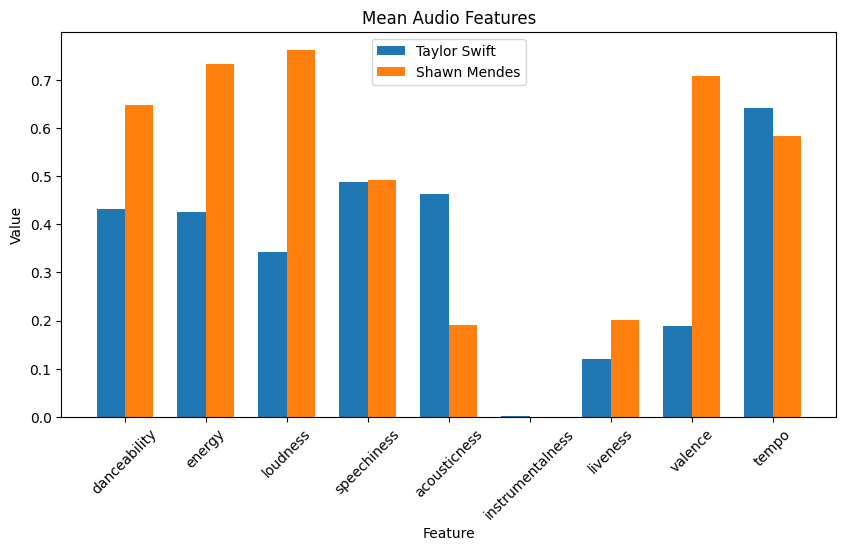

In [56]:
import numpy as np
def plot_audio_features ( artists_audio_feat : pd.DataFrame , artist1_id : str , artist2_id : str) -> None :
    """
    Plot a ( single ) figure with a plot of mean audio features of two different artists .
    param artists_audio_feat : dataframe with mean audio features of artists .
    param artist1_id : string with id of artist 1.
    param artist2_id : string with id of artist 2.
    return : None
    """
    # Get the audio features for the two artists
    artist1_features = artists_audio_feat[artists_audio_feat['artist_id'] == artist1_id].iloc[0]
    artist2_features = artists_audio_feat[artists_audio_feat['artist_id'] == artist2_id].iloc[0]

    features = artist1_features[2:].index
    x = np.arange(len(features))  # the label locations
    width = 0.35  # the width of the bars

    # Create the plot
    plt.figure(figsize=(10, 5))
    plt.bar(x - width/2, artist1_features[2:], width, label=artist1_features ['artist_name'])
    plt.bar(x + width/2, artist2_features[2:], width, label=artist2_features ['artist_name'])

    plt.xlabel ('Feature')
    plt.xticks(x, features, rotation=45)
    plt.ylabel ('Value')
    plt.title ('Mean Audio Features')
    plt.legend ()
    plt.show ()
plot_audio_features(avergae_songs, '06HL4z0CvFAxyc27GXpf02', '7n2wHs1TKAczGzO7Dd2rGr')


In [83]:
def plot_similarity_heatmap ( artist_audio_features_df : pd . DataFrame , similarity : str , out_filename : str = None ) -> None :
    """
    Plot a heatmap of the similarity between artists .
    param artist_audio_features_df : dataframe with mean audio features of artists .
    param similarity : string with similarity measure to use.
    param out_filename : name of the file to save the plot . If None , the plot is not saved .
    """
    # Compute the similarity matrix
    if similarity == 'cosine':
        similarity_matrix = cosine_similarity(artist_audio_features_df.iloc[:, 2:])
    elif similarity == 'euclidean':
        similarity_matrix = euclidean_distances(artist_audio_features_df.iloc[:, 2:])

    # Create the plot
    plt.figure(figsize=(10, 10))
    plt.imshow(similarity_matrix, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title(f'Artist Similarity ({similarity})')
    plt.xlabel('Artist')
    plt.ylabel('Artist')
    
    # Save the plot if a filename is provided
    if out_filename:
        plt.savefig(out_filename)
    
    plt.show()

When Cosine Similarity is 1, Euclidean Distance is 0 (vectors are identical).
When Cosine Similarity is 0, Euclidean Distance is sqrt(2) (vectors are orthogonal).

{1: 7, 8: 13, 9: 6, 11: 3, 13: 4, 5: 5, 6: 9, 3: 13, 7: 7, 4: 13, 12: 4, 14: 2, 2: 9, 17: 1, 10: 2, 16: 1}


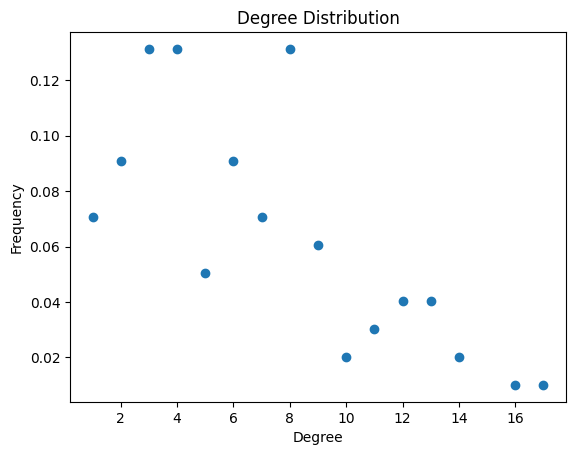

In [125]:
print(get_degree_distribution(undirected_gB))
plot_degree_distribution (get_degree_distribution(undirected_gB), normalized = True, loglog = False )


{1: 25, 3: 8, 2: 11, 5: 6, 4: 6, 7: 5, 6: 5, 8: 4, 11: 4, 14: 2, 16: 3, 13: 4, 15: 2, 12: 5, 9: 2, 18: 1}


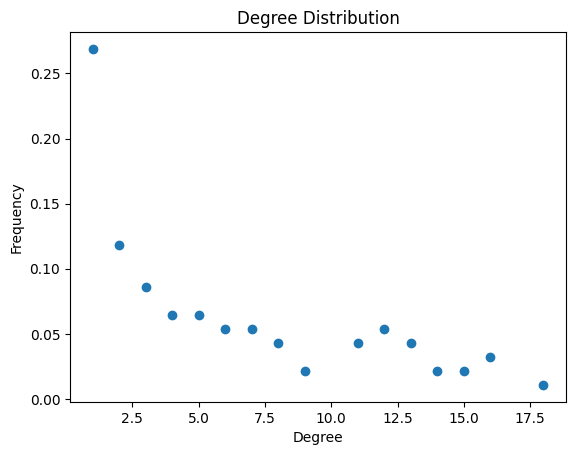

In [124]:
print(get_degree_distribution(undirected_gD))
plot_degree_distribution (get_degree_distribution(undirected_gD), normalized = True, loglog = False )


In [73]:
get_degree_distribution(G)

{124: 125}

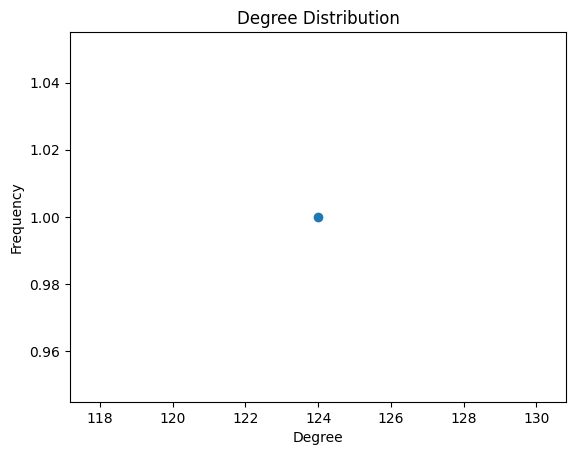

In [147]:
plot_degree_distribution (get_degree_distribution(G), normalized = True, loglog = False )


In [76]:
# Taylor Swift's node ID (assuming you know it or can find it)
taylor_swift_id = None
for node, data in G.nodes(data=True):
    if data.get('name') == 'Taylor Swift':
        taylor_swift_id = node
        break

if taylor_swift_id is None:
    print("Taylor Swift not found in the graph.")
else:
    max_weight = float('-inf')
    most_similar_artist_id = None

    # Iterate over the edges connected to Taylor Swift
    for neighbor, data in G[taylor_swift_id].items():
        weight = data.get('weight', 0)
        if weight > max_weight:
            max_weight = weight
            most_similar_artist_id = neighbor

    if most_similar_artist_id is None:
        print("Taylor Swift has no connections in the graph.")
    else:
        most_similar_artist_name = G.nodes[most_similar_artist_id]['name']
        print(f"The most similar artist to Taylor Swift is {most_similar_artist_name} with a similarity of {max_weight}")


The most similar artist to Taylor Swift is Gracie Abrams with a similarity of 0.53655979338147


In [77]:
# Taylor Swift's node ID (assuming you know it or can find it)
taylor_swift_id = None
for node, data in G.nodes(data=True):
    if data.get('name') == 'Taylor Swift':
        taylor_swift_id = node
        break

if taylor_swift_id is None:
    print("Taylor Swift not found in the graph.")
else:
    min_weight = float('inf')
    least_similar_artist_id = None

    # Iterate over the edges connected to Taylor Swift
    for neighbor, data in G[taylor_swift_id].items():
        weight = data.get('weight', 0)
        if weight < min_weight:
            min_weight = weight
            least_similar_artist_id = neighbor

    if least_similar_artist_id is None:
        print("Taylor Swift has no connections in the graph.")
    else:
        least_similar_artist_name = G.nodes[least_similar_artist_id]['name']
        print(f"The least similar artist to Taylor Swift is {least_similar_artist_name} with a similarity of {min_weight}")


The least similar artist to Taylor Swift is Johnny Orlando with a similarity of 0.029583133328054435


In [80]:
# Get the artist ID for Taylor Swift
taylor_swift_id = get_id_from_name_in_dataframe(avergae_songs, 'Taylor Swift')
gracie_abrams_id = get_id_from_name_in_dataframe(avergae_songs, 'Gracie Abrams')
johnny_orlando_id = get_id_from_name_in_dataframe(avergae_songs, 'Johnny Orlando')

taylor_swift_id

'06HL4z0CvFAxyc27GXpf02'

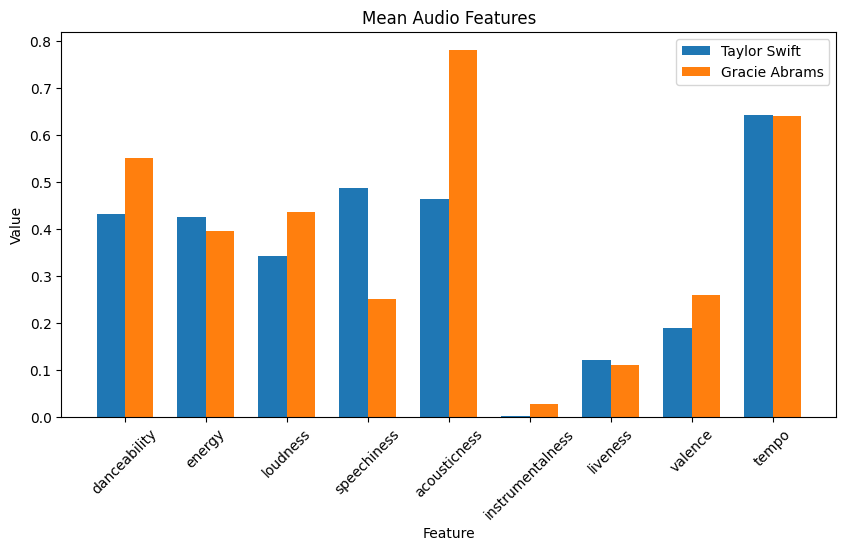

In [81]:
plot_audio_features(avergae_songs, taylor_swift_id, gracie_abrams_id)

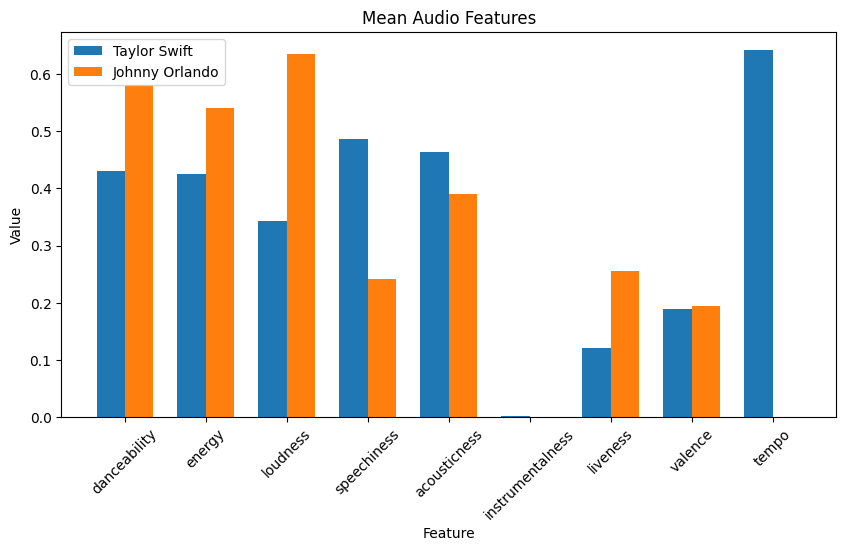

In [82]:
plot_audio_features(avergae_songs, taylor_swift_id, johnny_orlando_id)

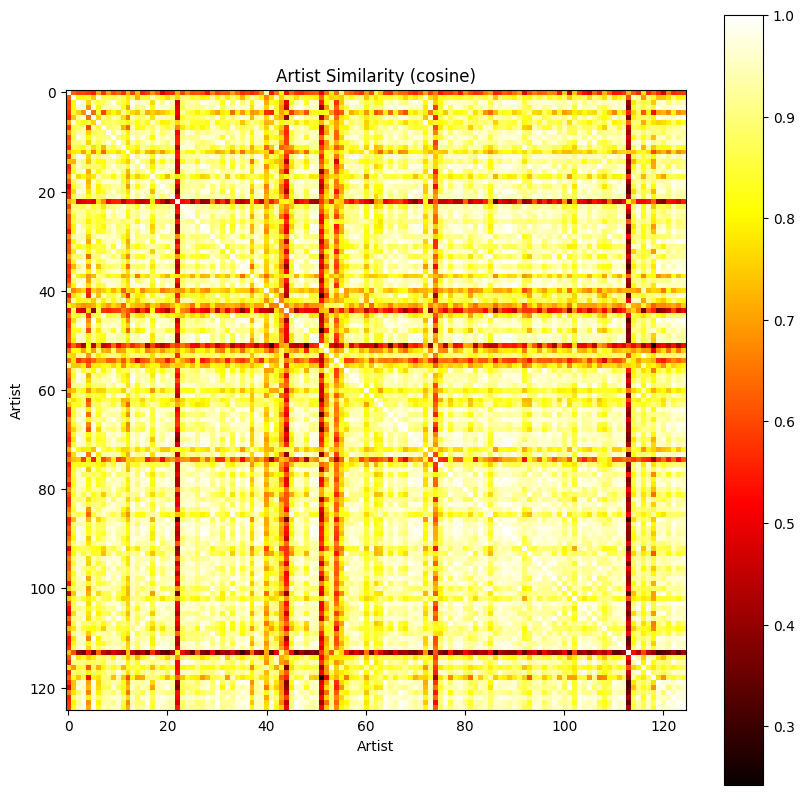

In [84]:
plot_similarity_heatmap(avergae_songs, 'cosine', 'similarity_heatmap.png')

In [123]:
g_similarity=G.copy()
pruned_gw = prune_low_weight_edges (g_similarity, min_weight = 0.45, out_filename = 'pruned_G.graphml')
biggest_connected_components_gw = max(nx.connected_components(pruned_gw), key=len)
len(biggest_connected_components_gw)

42

In [144]:
g_similarity=G.copy()
pruned_gw = prune_low_weight_edges (g_similarity, min_percentile = 69.6, out_filename = 'pruned_G.graphml')
biggest_connected_components_gw = max(nx.connected_components(pruned_gw), key=len)
len(biggest_connected_components_gw)

125

In [146]:
g_similarity=G.copy()
pruned_gw = prune_low_weight_edges (g_similarity, min_percentile = 69.7, out_filename = 'pruned_G.graphml')
biggest_connected_components_gw = max(nx.connected_components(pruned_gw), key=len)
len(biggest_connected_components_gw)

124

In [148]:
path_length = nx.shortest_path_length(gD, source=taylor_swift_id, target=gracie_abrams_id)
path_length

2

In [149]:
path_length = nx.shortest_path_length(gB, source=taylor_swift_id, target=gracie_abrams_id)
path_length

2

In [150]:
path_length = nx.shortest_path_length(gB, source=taylor_swift_id, target=johnny_orlando_id)
path_length

3

In [151]:
path_length = nx.shortest_path_length(gD, source=taylor_swift_id, target=johnny_orlando_id)
path_length

4

In [157]:
shortest_paths = nx.single_source_shortest_path_length(undirected_gB, source=taylor_swift_id)

# Find the most distant neighbor and its distance
most_distant_neighbor, distance = max(shortest_paths.items(), key=lambda x: x[1])

print("Most distant neighbor:", most_distant_neighbor)
print("Distance from Taylor Swift:", distance)


Most distant neighbor: 3yY2gUcIsjMr8hjo51PoJ8
Distance from Taylor Swift: 7


In [11]:
import pandas as pd

file_path = 'gD.csv'
data = pd.read_csv(file_path)

data.head(), data.columns

(                       Id                   Label                  d3   d2  \
 0  06HL4z0CvFAxyc27GXpf02  06HL4z0CvFAxyc27GXpf02                 pop  100   
 1  0C8ZW7ezQVs4URX5aX7Kqx  0C8ZW7ezQVs4URX5aX7Kqx  pop, post-teen pop   79   
 2  1McMsnEElThX1knmY4oliG  1McMsnEElThX1knmY4oliG                 pop   86   
 3  6jJ0s89eD6GaHleKKya26X  6jJ0s89eD6GaHleKKya26X                 pop   81   
 4  66CXWjxzNUsdJxJ2JdwvnR  66CXWjxzNUsdJxJ2JdwvnR                 pop   90   
 
           d1              d0  Eccentricity  closnesscentrality  \
 0  110764501    Taylor Swift            32            0.056614   
 1   49330906    Selena Gomez             0            0.000000   
 2   36034194  Olivia Rodrigo             0            0.000000   
 3   33120281      Katy Perry             0            0.000000   
 4   96443739   Ariana Grande             0            0.000000   
 
    harmonicclosnesscentrality  betweenesscentrality  modularity_class Filter  \
 0                    0.122464         

In [13]:
grouped_data = data.groupby('modularity_class')

def get_community_characteristics(group):
    characteristics = {}
    characteristics['count'] = group['Id'].count()
    characteristics['common_genres'] = group['d3'].mode().values
    characteristics['mean_closeness_centrality'] = group['closnesscentrality'].mean()
    characteristics['mean_betweenness_centrality'] = group['betweenesscentrality'].mean()
    characteristics['mean_harmonic_closeness_centrality'] = group['harmonicclosnesscentrality'].mean()
    return characteristics

community_characteristics = grouped_data.apply(get_community_characteristics)

# Convert the series of dictionaries into dataframe
community_characteristics_df = pd.DataFrame(community_characteristics.tolist(), index=community_characteristics.index).reset_index()

community_characteristics_df

/tmp/ipykernel_612/2963213808.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  community_characteristics = grouped_data.apply(get_community_characteristics)


modularity_class  count                           common_genres  \
0                 0     99                                   [pop]   
1                 1     86                         [post-teen pop]   
2                 2     34                                  [idol]   
3                 3     40                             [hollywood]   
4                 4     49                               [gymcore]   
5                 5     50                               [gymcore]   
6                 6    109             [gymcore, hard alternative]   
7                 7     30  [alternative metalcore, rap metalcore]   
8                 8    110                         [rap metalcore]   

   mean_closeness_centrality  mean_betweenness_centrality  \
0                   0.005049                   109.656566   
1                   0.008010                   414.802326   
2                   0.005689                   422.382353   
3                   0.008695                   556.650000   
4                   0.009466                   321.227891   
5                   0.019472                   292.849899   
6                   0.043148                   421.938884   
7                   0.021659                   461.200000   
8                   0.152964                   184.090909   

   mean_harmonic_closeness_centrality  
0                            0.010880  
1                            0.015525  
2                            0.010225  
3                            0.014753  
4                            0.014535  
5                            0.030514  
6                            0.060607  
7                            0.028417  
8                            0.194540

In [14]:
# Load the other dataset
file_path = 'gB.csv'
data = pd.read_csv(file_path)

In [15]:
grouped_data = data.groupby('modularity_class')

def get_community_characteristics(group):
    characteristics = {}
    characteristics['count'] = group['Id'].count()
    characteristics['common_genres'] = group['d3'].mode().values
    characteristics['mean_closeness_centrality'] = group['closnesscentrality'].mean()
    characteristics['mean_betweenness_centrality'] = group['betweenesscentrality'].mean()
    characteristics['mean_harmonic_closeness_centrality'] = group['harmonicclosnesscentrality'].mean()
    return characteristics

community_characteristics = grouped_data.apply(get_community_characteristics)

# Convert the series of dictionaries into dataframe
community_characteristics_df = pd.DataFrame(community_characteristics.tolist(), index=community_characteristics.index).reset_index()

community_characteristics_df

/tmp/ipykernel_612/2963213808.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  community_characteristics = grouped_data.apply(get_community_characteristics)


modularity_class  count                                      common_genres  \
0                 0     68                                              [pop]   
1                 1    129                                       [pov: indie]   
2                 2     46                                    [post-teen pop]   
3                 3     64                                   [dance pop, pop]   
4                 4     15  [alternative rock, art pop, dream pop, etherea...   
5                 5     67                                            [alt z]   
6                 6     31                                              [pop]   
7                 7     53                                      [movie tunes]   

   mean_closeness_centrality  mean_betweenness_centrality  \
0                   0.150404                   559.099188   
1                   0.050420                   324.942881   
2                   0.043198                   284.594775   
3                   0.067648                   209.055855   
4                   0.010584                    95.009511   
5                   0.028241                   134.796225   
6                   0.037533                   214.239373   
7                   0.021492                   107.788281   

   mean_harmonic_closeness_centrality  
0                            0.175221  
1                            0.058882  
2                            0.050644  
3                            0.081527  
4                            0.013841  
5                            0.033280  
6                            0.043556  
7                            0.024831